Welcome to the "Coin Detection with U-Net" project!

**Project Overview:**

In this notebook, we'll go step by step through the process of creating a U-Net architecture from scratch, training it on a dataset of coin images, and using it to detect and segment coins in unseen images.

## Importing Libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import time

## Loading the Dataset

In [2]:
%%capture
if not os.path.exists("/content/public_coin_dataset.zip"):
  !gdown 1cF-u9N7miok5-KUiriTdvA62edxIs1I_
  !unzip "/content/public_coin_dataset.zip" -d "/content/dataset"

In [3]:
# Defining the desired width and height for training the model

global image_h
global image_w

## Defining Some Functions

In [4]:
def create_dir(path):
  """
    Create a directory if it does not exist.

    This function checks if a directory specified by the `path` parameter exists.
    If it doesn't exist, the function creates the directory.

    Args:
        path (str): The path to the directory to be created.
    """

  if not os.path.exists(path):
      os.makedirs(path)

In [5]:
def load_dataset(path, split=0.1):
    """
    Load a dataset of images and corresponding masks, and split it into training and testing sets.

    Args:
        path (str): The path to the root directory containing the dataset.
        split (float): The proportion of the dataset to use for testing. Should be between 0 and 1.

    Returns:
        Tuple[Tuple[List[str], List[str]], Tuple[List[str], List[str]]]:
            A tuple containing two tuples. The first tuple contains lists of training
            image file paths and training mask file paths. The second tuple contains
            lists of validation image file paths and validation mask file paths.
    """
    # Loading the images and masks.

    data_paths = [os.path.join(dataset_path,data) for data in os.listdir(path)]
    X = [os.path.join(data_path,'original','coin.jpeg') for data_path in data_paths]
    Y = [os.path.join(data_path,'no_bg','coin.jpeg') for data_path in data_paths]

    # Spliting the data into training and testing.
    split_size = int(len(X) * split)

    train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

In [6]:
def read_image(path):
    """
    Read and preprocess an image from the given file path.

    Args:
        path (str): The file path to the image.

    Returns:
        numpy.ndarray: The preprocessed image as a NumPy array with shape (image_h, image_w, 3).

    """
    path = path.decode()  # Decode the file path if it's stored as bytes
    x = cv2.imread(path, cv2.IMREAD_COLOR)  # Read the image in color (RGB)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB color format
    x = cv2.resize(x, (image_w, image_h))  # Resize the image
    x = x / 255.0  # Normalize pixel values to [0, 1]
    x = x.astype(np.float32)  # Convert image data to float32
    return x

def read_mask(path):
    """
    Read and preprocess a mask image from the given file path.

    Args:
        path (str): The file path to the mask image.

    Returns:
        numpy.ndarray: The preprocessed mask image as a NumPy array with shape (image_h, image_w, 1).
    """
    path = path.decode()  # Decode the file path if it's stored as bytes
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read the mask image in grayscale
    x = cv2.resize(x, (image_w, image_h))  # Resize the mask image
    x = x.astype(np.float32)  # Convert image data to float32
    x = np.expand_dims(x, axis=-1)  # Add a channel dimension to the mask
    return x

def tf_parse(x, y):
    """
    Parse and preprocess image and mask tensors for TensorFlow dataset.

    Args:
        x (str): The file path to the image.
        y (str): The file path to the mask image.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the preprocessed image and mask tensors.
    """
    def _parse(x, y):
        # Read and preprocess the image
        x = read_image(x)

        # Read and preprocess the mask
        y = read_mask(y)

        return x, y

    # Apply the parsing function to the input tensors
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])

    # Set the shapes for the tensors
    x.set_shape([image_h, image_w, 3])
    y.set_shape([image_h, image_w, 1])

    # Convert mask values to binary (0 or 1)
    y = tf.where(y != 0, 1, 0)
    return x, y

In [7]:
def tf_dataset(X, Y, batch_size, mode = 'train'):
    """
    Create a TensorFlow dataset for machine learning model training or evaluation.

    This function takes feature data paths `X`, target data paths `Y`, and other parameters to create
    a TensorFlow dataset suitable for training or evaluation. Depending on the `mode`
    parameter, it can perform data preprocessing, shuffling, batching, repetition, and
    prefetching.

    Args:
        X (Tuple[List[str], List[str]): This tuple contains lists of training image file paths and training mask file paths.
        Y (Tuple[List[str], List[str]): This tuple contains lists of validation image file paths and validation mask file paths.
        batch_size (int): Number of samples per batch.
        mode (str, optional): Mode of the dataset. Set to 'train' for training mode,
            or 'eval' for evaluation/inference mode. Defaults to 'train'.

    Returns:
        tf.data.Dataset: A TensorFlow dataset ready for training or evaluation.
    """

    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if mode == 'train':
      # Apply data preprocessing (e.g., augmentation) in parallel
      ds = ds.map(tf_parse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      # Shuffle, batch, repeat, and prefetch for training
      ds = ds.shuffle(1000).batch(batch_size).repeat()
      ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    elif mode == 'eval':
      # Apply data preprocessing and batch for evaluation/inference
      ds = ds.map(tf_parse).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

### Processing the datasets and creating tensorflow dataset objects

In [8]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Directory for storing files
create_dir("results")

# Hyperparameters
image_h = 256
image_w = 256
input_shape = (image_h, image_w, 3)
batch_size = 16


# Paths
dataset_path = '/content/dataset/public_coin_dataset'
model_path = os.path.join("results", "model.h5")
csv_path = os.path.join("results", "data.csv")

# Loading the dataset
(train_x, train_y), (valid_x, valid_y) = load_dataset(dataset_path, split=0.2)
print(f"Training: {len(train_x)}/{len(train_y)} - Validation: {len(valid_x)}/{len(valid_y)}")
print("")

# Dataset Pipeline
train_ds = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_ds = tf_dataset(valid_x, valid_y, batch_size=batch_size, mode = 'eval')

Training: 120/120 - Validation: 30/30



In [9]:
def display(display_list, titles=[], display_string=None):
    """
    Display a list of images along with optional titles and a description.

    Args:
        display_list (list of numpy.ndarray): List of images to display.
        titles (list of str, optional): List of titles for each image. Defaults to an empty list.
        display_string (str, optional): A description to display below the second image. Defaults to None.
    """
    plt.figure(figsize=(10, 10))

    for i in range(len(display_list)):
        # Create a subplot for each image, arranging them in a single row.
        plt.subplot(1, len(display_list), i + 1)

        # Set the title for the current subplot (if provided).
        plt.title(titles[i])

        # Remove x and y ticks to make the plot cleaner.
        plt.xticks([])
        plt.yticks([])

        # If a display_string is provided and this is the second image, add it as a label below the image.
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)

        # Convert the current image to a displayable format and show it in the subplot.
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)

    # Show the entire figure with subplots.
    plt.show()

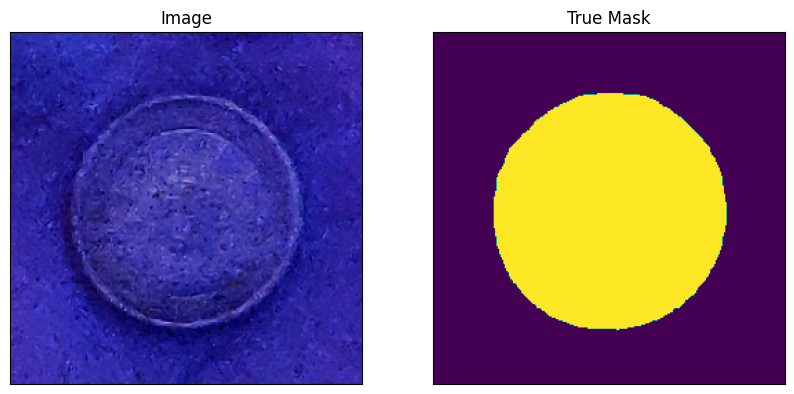

In [10]:
# Unbatch the training dataset to get individual image-mask pairs and shuffle them
data = train_ds.unbatch().shuffle(100)

# Take one image-mask pair from the shuffled dataset
for image, mask in data.take(1):
    # Display the image and its true mask
    display(display_list=[image, mask], titles=["Image", "True Mask"])

## Unet Model

In [11]:
# laoding the model.py file which contains the model architecture inside it.
import requests
from pathlib import Path

if Path("model.py").is_file():
  print("model.py already exists, skipping download")
else:
  print("Downloading model.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/MarwanMohamed95/Tech-Test-ML-Coin/main/From%20Scratch/model.py")
  with open("model.py", "wb") as f:
    f.write(request.content)

In [12]:
# Initiating the Mode
from model import unet_from_scratch
model = unet_from_scratch(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

## Compiling and training the model

In [13]:
learning_rate = 1e-4
num_epochs = 50
train_length = len(train_x)
steps_per_epoch = train_length // batch_size
validation_steps = 1

In [14]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
# Training
callbacks = [
    ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

history = model.fit(train_ds,
                          epochs=num_epochs,
                          steps_per_epoch = steps_per_epoch,
                          validation_steps = validation_steps,
                          validation_data = valid_ds,
                          callbacks = callbacks
                          )

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.5508
Epoch 1: val_accuracy improved from -inf to 0.72272, saving model to results/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 58s 2s/step - loss: 0.7303 - accuracy: 0.5508 - val_loss: 0.6258 - val_accuracy: 0.7227
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.6530 - accuracy: 0.6182
Epoch 2: val_accuracy improved from 0.72272 to 0.77411, saving model to results/model.h5
7/7 [==============================] - 22s 1s/step - loss: 0.6530 - accuracy: 0.6182 - val_loss: 0.5798 - val_accuracy: 0.7741
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.6884
Epoch 3: val_accuracy did not improve from 0.77411
7/7 [==============================] - 8s 1s/step - loss: 0.5939 - accuracy: 0.6884 - val_loss: 0.5147 - val_accuracy: 0.6692
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7792
Epoch 4: val_accuracy did not improve from 0.77411
7/7 [==============================] - 7s 1s/step - loss: 0.5006 - accuracy: 0.7792 - val_loss: 0.6040 - val_accuracy: 0.6288
Epoch 5/50
7/7 [===========

Model saved to https://drive.google.com/file/d/1ljp8Ssu_TZAnv03-vGTnVKkFJPaovU7W/view?usp=drive_link

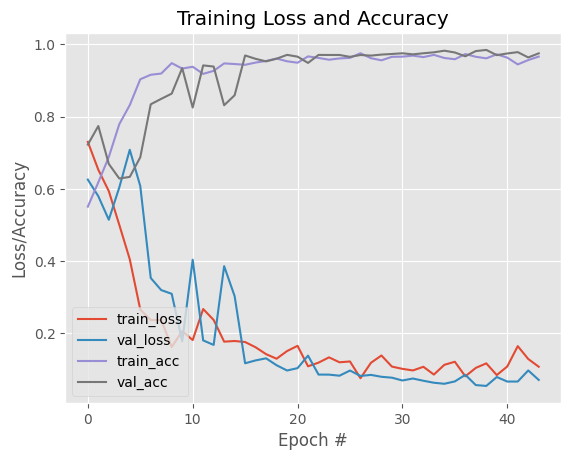

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
num_trained_epochs = len(history.history["loss"])
plt.plot(np.arange(0, num_trained_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_trained_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_trained_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_trained_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

### Evaluating the model and Computing Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [14]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(2):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

## Make Predictions

In [11]:
def predict_and_show_results(image_path, mask_path, model):
    """
    Predicts the mask of a coin in an image, post-processes the mask, and displays the results.

    Args:
        image_path (str): The file path to the input image.
        mask_path (str): The file path to the true mask.
        model (tf.keras.Model): The trained model for mask prediction.
    """
    # Reading the input image and true mask
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = np.expand_dims(true_mask, axis=-1)
    true_mask[true_mask != 0] = 1

    # Resize the input image
    h, w, _ = image.shape
    x = cv2.resize(image, (image_w, image_h))
    x = x / 255.0
    x = x.astype(np.float32)  # (image_w, image_h, 3)
    x = np.expand_dims(x, axis=0)  # (1, image_w, image_h, 3)

    # Prediction
    y_pred_mask = model.predict(x, verbose=0)
    y_pred_mask = tf.argmax(y_pred_mask, axis=-1)
    y_pred_mask = y_pred_mask[..., tf.newaxis]
    y_pred_mask = y_pred_mask[0].numpy()

    # Post-processing (Dilate and Erode)
    kernel_dilate = np.ones((5, 5), dtype=np.uint8)
    y_pred_mask = cv2.dilate(y_pred_mask.astype('uint8'), kernel_dilate, iterations=1)
    kernel_erode = np.ones((3, 3), dtype=np.uint8)
    y_pred_mask = cv2.erode(y_pred_mask.astype('uint8'), kernel_erode, iterations=1)

    y_pred_mask = cv2.resize(y_pred_mask, (w, h))
    y_pred_mask = np.expand_dims(y_pred_mask, axis=-1)

    # Create a copy of the original image for visualization
    image_copy = image.copy()

    # Find contours in the grayscale predicted mask
    contours, _ = cv2.findContours(y_pred_mask.squeeze().astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area (assuming it's the coin)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the area and radius of the largest contour
    area = cv2.contourArea(largest_contour)
    radius = np.sqrt(area / np.pi)

    # Calculate the centroid (center) of the contour
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Draw a circle at the center of the contour on the image copy
    contour_image = cv2.circle(image_copy, (cX, cY), int(radius), (0, 255, 0), 2)  # Green circle

    # Computing the class wise metrics
    class_names = ['coin', 'background']
    iou_list, dice_score_list = class_wise_metrics(true_mask, y_pred_mask)
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

    display_string_list = ["{}: IOU: {}  Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n".join(display_string_list)
    print(display_string)
    print("\n")
    # Display the original image, predicted mask, true mask, and image with the detected coin
    display([image, y_pred_mask, true_mask, contour_image], titles=["Image", "Predicted Mask", "True Mask", "Image with Coin Detected"])

In [12]:
# Loading the model
!gdown 1ljp8Ssu_TZAnv03-vGTnVKkFJPaovU7W

Downloading...
From: https://drive.google.com/uc?id=1ljp8Ssu_TZAnv03-vGTnVKkFJPaovU7W
To: /content/model.h5
100% 414M/414M [00:13<00:00, 31.0MB/s]


coin: IOU: 0.979353816597955  Dice Score: 0.9895692305932707
background: IOU: 0.9677563697705421  Dice Score: 0.9836140131644867




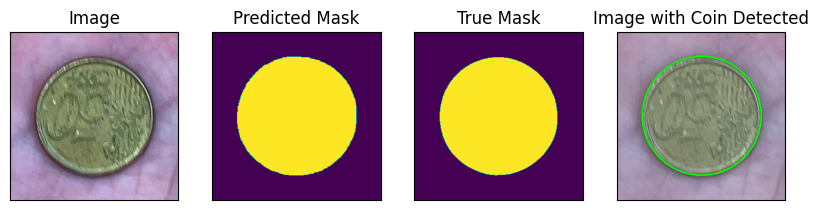


Time for Prediction takes: 1.42 seconds


In [15]:
model = tf.keras.models.load_model("model.h5")

# choose random image
random_image  = np.random.choice(len(valid_x))
image_path = valid_x[random_image]
mask_path = valid_y[random_image]

start_time = time.time()
predict_and_show_results(image_path,mask_path, model)
end_time = time.time()
print(f"\nTime for Prediction takes: {end_time - start_time:.2f} seconds")